# FYP Project 2 Group G

#### How to run this notebook

...

### Research Question
[the question]

In [ ]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import Config
import os, sys
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import skimage.io as sk
from skimage import morphology
from skimage.color import rgb2gray
from statsmodels.robust import mad
from PIL import Image
import ptitprince as pt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


### Dataframes

In [ ]:
df = pd.read_csv(Config.features_path) #the main dataframe

mel_df = pd.read_csv(Config.example_ground_truth_path)
df['melanoma'] = mel_df['melanoma']

## Task 0 - exploring the data 
Investigating the data provided by our teacher - looking for missing values in .csv files as well as getting familiar with the data using the df.describe() function.

In [ ]:
#getting the shape of df
print(f'shape of the main df: {df.shape}')

#looking for missing data
print(f'Are there any missing values in the dataset? {df.isna().any().any()}')

#getting the diagnosis types
print('')
print(f'The diagnosis types: {mel_df.columns[1:]}')

shape of the main df: (150, 4)
Are there any missing values in the dataset? False

The diagnosis types: Index(['melanoma', 'seborrheic_keratosis'], dtype='object')


In [ ]:
df.describe()

,area,perimeter,melanoma
count,1.500000e+02,150.00000,150.00000
mean,3.114134e+06,5570.36000,0.20000
std,5.897570e+06,5294.59662,0.40134
min,3.294400e+04,642.00000,0.00000
25%,2.329922e+05,2014.50000,0.00000
50%,6.223165e+05,3324.50000,0.00000
75%,2.054852e+06,7137.50000,0.00000
max,2.770686e+07,25900.00000,1.00000


## Task 1 - measuring the features ourselves

In [ ]:
## TODO - add plots of our guesses

## Task 2 - creating our feature measurements

### Picture Class
This class contains all the feature functions that we apply for each image as well as a function that measures the area & perimeter of an image.

In [ ]:
class Picture:
    def __init__(self, img, img_bw):
        self.img = img #main image
        self.img_bw = self._cut_image(img_bw) #the image in black & white version

    #ASYMMETRY
    def _cut_image(self, picture):
        ''' Makes the number of pixels in width and height an even number  '''
        width, height = picture.size
        image = np.array(picture)
        
        if width %2 != 0:
            image = np.delete(image, -1, 1)

        if height %2 != 0:
            image = np.delete(image, -1, 0)

        image = Image.fromarray(image)

        return image

    def _asymmetry(self, rot_img):
        '''Gets the asymmetry between the left and right part of a given binary mask '''
        width, height = rot_img.size #mask should be quadratic and therefore have equal dimension
        size = width * height

        #check for uneven number of pixels (should not happen but just as a precaution)
        if width %2 != 0:
            raise TypeError('Uneven number of pixel and cannot be symmetric')
        
        #cut in half and fold
        left = rot_img.crop((0, 0, (width/2), height)) #left part of picture (left, top, right, bottom)
        right = rot_img.crop(((width/2), 0, width, height)) #right part of picture
        right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

        #get the binary difference between left an right
        symmetry = np.where(np.array(left) != np.array(right), 1, 0)

        return np.sum(symmetry) / (size/2) #the percentage of asymmetry 
    
    def get_asymmetry(self):
        '''Returns the asymmetry for a given mask by folding it in half from multiple angles'''
        return round(np.mean([self._asymmetry(self.img_bw), self._asymmetry(self.img_bw.rotate(30, expand= True)),self._asymmetry(self.img_bw.rotate(60, expand= True)),self._asymmetry(self.img_bw.rotate(90, expand= True))]),2)

    #BORDER
    def measure_area_perimeter(self): #TODO (erase) Stolen from Veronika's github
        '''Measures the area and perimeter of a mask image '''
        #area: the sum of all white pixels in the mask image
        mask = np.where(np.array(self.img_bw)==255, 1, 0)
        area = np.sum(mask)

        #perimeter: first find which pixels belong to the perimeter.
        struct_el = morphology.disk(1)
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        image_perimeter = mask - mask_eroded

        #now we have the perimeter image, the sum of all white pixels in it
        perimeter = np.sum(image_perimeter)

        return area, perimeter

    def get_compactness(self):
        ''' Computes and returns the compactness of a figure '''
        area, perimeter = self.measure_area_perimeter()
        return round(4*np.pi*area / perimeter ** 2, 4)


    #COLOR
    def get_color_variability(self):
        '''Assigns a color variability score'''
        if self._check_variability() < 20: 
            return 0 
        elif self._check_variability() < 50: 
            return 1
        else: 
            return 2

    def _check_variability(self):
        '''Returns a mean of the median absolute deviation of each color (rgb)'''
        self.img[self.img_bw==0] = 0
        
        #we then calculate the mad of each dimension 
        r, g, b = self.img[:,:,0], self.img[:,:,1], self.img[:,:,2]
        mad_r= mad(r[np.where(r != 0)])
        mad_g= mad(g[np.where(g != 0)])
        mad_b= mad(b[np.where(b != 0)])
        mad_result= [mad_r,mad_g,mad_b]

        #calculating the mean
        return np.mean(mad_result)
    

### Visualizing the feature functions
Creating plots of each feature function in order to explore our measurements.

#### Asymmetry plots

In [ ]:
# TODO - add plots of asymmetry

#### Border plots

In [ ]:
# TODO - add plots of border

#### Color plots

In [ ]:
# TODO - add plots of color

## Task 3 - predicting the diagnosis

#### get_row()

In [ ]:
# TODO - add get_row

#### train_evaluate_classifiers()

In [ ]:
# TODO - add train_evaluate_classifiers

### Main()
The `main()` functon iterates over each image, creates an instance of the `Picture` class, and adds a row to a dataframe with all functions using the `get_row()` function. Ultimately, it returns the `train_evaluate_classifiers()` function with the dataframe mentioned above as the attribute.

In [ ]:
#TODO - add main

## Task 4 - open question

In [ ]:
#M,N is the range of images that we choosen (finally it will be 0-# of images)
N = 0
M = 150

feat_dict = {
    'asymmetry': [0 for _ in range(M-N)],
    'border': [0 for _ in range(M-N)],
    'color': [0 for _ in range(M-N)]
}


#the main for loop which loads the images
for (index, id) in enumerate(df['id'][N:M]):
    img = plt.imread(f'../data/example_image/{id}.jpg') #main image
    #img_bw = plt.imread(f'../data/example_segmentation/{id}_segmentation.png') #main image grayed

    file_mask = f'../data/example_segmentation/{id}_segmentation.png'
    
    # Read the images with these filenames
    img_bw = Image.open(file_mask) # open mask image
    perimeter, area = df[df['id'] == id]['perimeter'].iloc[0], df[df['id'] == id]['area'].iloc[0]


    is_cancer = df[df['id'] == id]['melanoma'].iloc[0] #TMP

    image = Picture(img, img_bw)

    feat_dict["asymmetry"][index] = image.get_asymmetry()
    feat_dict["border"][index] = round(image.get_compactness(), 3)
    feat_dict["color"][index] = image.get_color_variability()


In [ ]:
#feat_df = pd.DataFrame()
#feat_df = feat_dict.append(feat_dict, ignore_index=True)
df['asymmetry'] = feat_dict['asymmetry']
df['border'] = feat_dict['border']
df['color'] = feat_dict['color']
df

ValueError: Length of values (30) does not match length of index (150)

In [ ]:
# Stolen from Veronika's github example

def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # Now we have the perimeter image, the sum of all white pixels in it
    perimeter = np.sum(image_perimeter)
 
    return area, perimeter

## PLOTS

<AxesSubplot:>

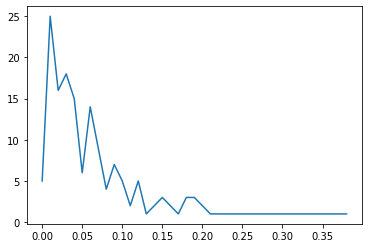

In [ ]:
#creating a lineplot of the distribution of the assymetry values
for_plot = np.unique(df["asymmetry"], return_counts=True)
sns.lineplot(x=for_plot[0], y=for_plot[1])

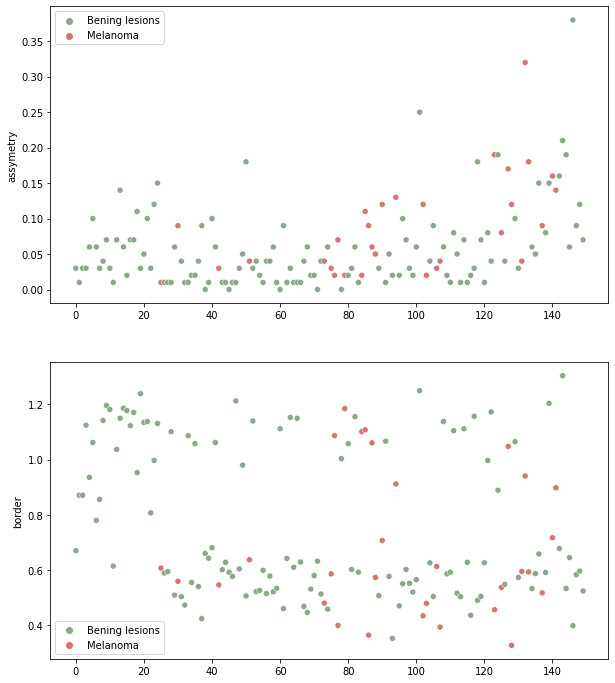

In [ ]:
#create a scatterplot that shows the assymetry on the y axis 
#melanoma are colored red, benign lesions are colored green
colors1 = ['#8BA888','#D67573']
colors = ["Bening lesions" if df['melanoma'][x] == 0.0 else 'Melanoma' for x in range(len(df['melanoma'])) ]

fig, axes = plt.subplots(2,1,figsize = (10,12))

for i, ax in enumerate(axes):
    xs = [i for i in range(len(df["assymetry"]))]
    ys = ["asymmetry", "border"]
    sns.scatterplot(x=xs, y= df[ys[i]], hue=colors, palette=colors1, ax=ax)
    
    


Text(0.5, 1.0, 'Raincloud plot of the melanoma assymetry')

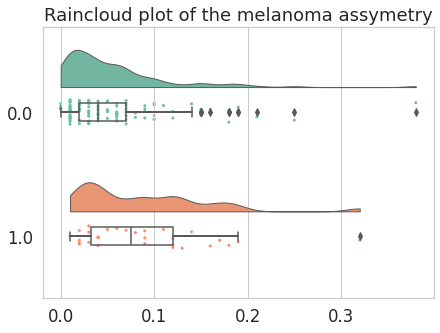

In [ ]:
#create a rain cloud plot that plots the asymmetry distribution for the two different groups (melanoma, benign)
sns.set(style="whitegrid",font_scale=1.5)

dx = list(df["melanoma"]); dy = list(df["asymmetry"])
f, ax = plt.subplots(figsize = (7,5))
sigma = .2; ort = "h"

ax = pt.RainCloud(x = dx, y = dy, width_viol = .6, ax = ax, bw = sigma, orient= ort)
plt.title("Raincloud plot of the melanoma asymmetry")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=932aa97b-f6d2-4889-8f04-d6166675cc2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>